In [1]:
# import necessary libraries
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [2]:
# Create environment
env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
state_size = env.observation_space.n
print("State size: ", state_size)

action_size = env.action_space.n
print("Action size: ", action_size)

State size:  500
Action size:  6


### Actions
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

In [4]:
done = False
env.reset()
env.render()
while not done:
    action = int(input('0/south 1/north 2/east 3/west 4/pickup 5/drop:'))
    new_state, reward, done, info = env.step(action)
    time.sleep(1.0) 
    print(f'S_t+1={new_state}, r_t+1={reward}, done={done}')
    env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



KeyboardInterrupt: Interrupted by user

In [5]:
def eval_policy(env_, pi_, gamma_, t_max_, episodes_):
    env_.reset()

    v_pi_rep = np.empty(episodes_)
    for e in range(episodes_):
        s_t = env.reset()
        v_pi = 0
        for t in range(t_max_):
            a_t = pi_[s_t]
            s_t, r_t, done, info = env_.step(a_t) 
            v_pi += gamma_**t*r_t
            if done:
                break
        v_pi_rep[e] = v_pi
        env.close()
        
    return np.mean(v_pi_rep), np.min(v_pi_rep), np.max(v_pi_rep), np.std(v_pi_rep)

In [6]:
qtable = np.zeros((500,6)) # Taxi v3
episodes = 1500 # num of training episodes
interactions = 666 # max num of interactions per episode
epsilon = 0.99 # e-greedy
alpha = 0.5 # learning rate 1.
gamma = 0.9 # reward decay rate
hist = [] # evaluation history

# Main Q-learning loop
for episode in range(episodes):
    
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for interact in range(interactions):
        # exploitation vs. exploratin by e-greedy sampling of actions
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(qtable[state,:])
        else:
            action = np.random.randint(0,6)

        # Observe
        new_state, reward, done, info = env.step(action)

        # Update Q-table
        qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # Check if terminated
        if done == True: 
            break
    
    if episode % 10 == 0 or episode == 1:
        pi = np.argmax(qtable, axis=1)
        val_mean, val_min, val_max, val_std = eval_policy(env, pi, gamma, interactions, episodes)
        hist.append([episode, val_mean,val_min,val_max,val_std])

env.reset()

274

(151, 5)


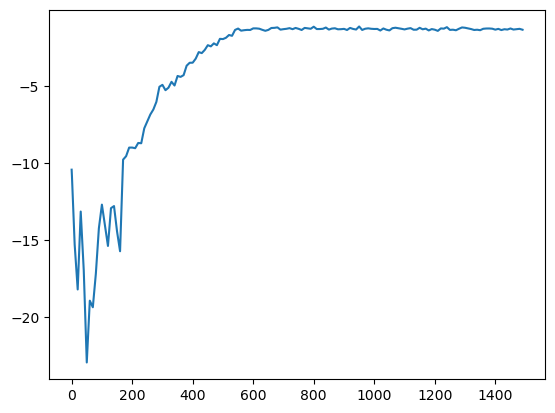

In [7]:
hist = np.array(hist)
print(hist.shape)

plt.plot(hist[:,0],hist[:,1])
plt.show()

(151, 5)


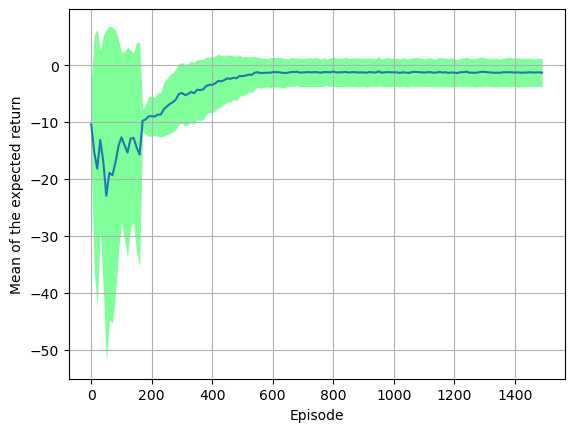

In [8]:
hist = np.array(hist)
print(hist.shape)

plt.plot(hist[:,0],hist[:,1])
# Zero-clipped
#plt.fill_between(hist[:,0], np.maximum(hist[:,1]-hist[:,4],np.zeros(hist.shape[0])),hist[:,1]+hist[:,4],
plt.fill_between(hist[:,0], hist[:,1]-hist[:,4],hist[:,1]+hist[:,4],
                alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99', linewidth=0)

plt.xlabel("Episode")
plt.ylabel("Mean of the expected return")
plt.grid()
plt.show()

In [9]:
qtable

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.58568309,  0.4603522 , -0.58568312,  0.46035222,  1.6226136 ,
        -8.53964785],
       [ 4.34833541,  5.94254263,  4.34843789,  5.94267534,  7.71441623,
        -3.05725522],
       ...,
       [ 7.71469981,  9.6829999 ,  7.7146999 ,  5.9432291 , -1.2853001 ,
        -1.28530026],
       [ 1.62118768,  2.91245112,  1.62114926,  2.91187248, -7.37883966,
        -7.37898785],
       [14.29978534, 11.8650599 , 14.2976095 , 16.999998  ,  5.29998463,
         5.29936887]])

In [10]:
# Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(state_size,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(action_size, activation='linear')
])

In [11]:
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               64128     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 81,414
Trainable params: 81,414
Non-trainable params: 0
_________________________________________________________________


In [12]:
# one hot encoding the states (inputs)
x =  np.zeros((state_size, state_size))
for i in range(state_size):
    x[i][i] = 1
    
x

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
best_action=np.zeros(state_size)
for i in range(state_size):
    best_action[i] = np.argmax(qtable[i])

y = best_action
y

array([0., 4., 4., 4., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 5.,
       0., 0., 2., 0., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 2., 0., 2., 2., 0., 0., 0.,
       0., 2., 2., 0., 0., 0., 2., 0., 2., 0., 0., 0., 3., 2., 0., 2., 2.,
       3., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 3., 4.,
       0., 4., 4., 3., 0., 0., 3., 0., 3., 0., 0., 0., 5., 3., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 3., 0., 0., 0., 0., 0., 2., 0., 2., 2., 0., 0., 0., 0., 2.,
       2., 0., 0., 0., 2., 0., 0., 0., 0., 3., 3., 1., 0., 2., 2., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 3., 3., 1., 0., 1.,
       1., 3., 3., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 0., 1., 1., 1.,
       2., 0., 2., 2., 0., 0., 0., 0., 2., 2., 2., 0., 1., 2., 0., 2., 0.,
       3., 1., 3., 2., 0.

In [14]:
history = model.fit(x,y, epochs=100, steps_per_epoch=500)

Epoch 1/100
500/500 [==============================] - 3s 4ms/step - loss: 1.4446 - accuracy: 0.4020
Epoch 2/100
500/500 [==============================] - 2s 4ms/step - loss: 1.1585 - accuracy: 0.5580
Epoch 3/100
500/500 [==============================] - 3s 5ms/step - loss: 0.4383 - accuracy: 0.8780
Epoch 4/100
500/500 [==============================] - 3s 5ms/step - loss: 0.1030 - accuracy: 0.9740
Epoch 5/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0330 - accuracy: 0.9920
Epoch 6/100
500/500 [==============================] - 2s 4ms/step - loss: 0.0124 - accuracy: 1.0000
Epoch 7/100
500/500 [==============================] - 2s 4ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 8/100
500/500 [==============================] - 3s 5ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 9/100
500/500 [==============================] - 2s 3ms/step - loss: 9.9942e-04 - accuracy: 1.0000
Epoch 10/100
500/500 [==============================] - 2s 4ms/step - loss: 6.0794e-04 

500/500 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 80/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 81/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 82/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 83/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 84/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 85/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 86/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 87/100
500/500 [==============================] - 1s 

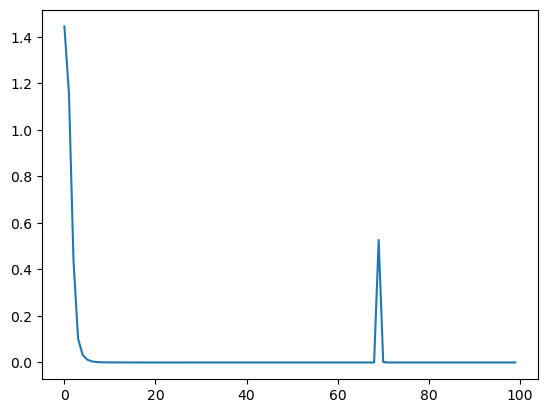

In [15]:
plt.plot(history.history['loss'])

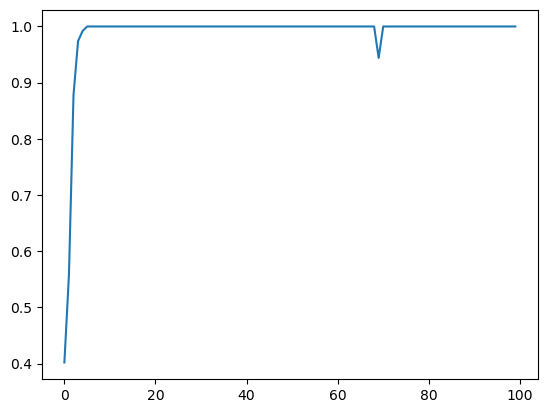

In [16]:
plt.plot(history.history['accuracy'])

In [17]:
new_state = np.array(env.reset())

done = False
while not done:
    new_state = tf.one_hot(new_state,500)
    action = model.predict(new_state)
    print(action)
    new_state, reward, done, _ = env.step(action)
    print(new_state)
    print(reward)
    print(done)
    env.render()
    time.sleep(0.1)
env.close()

ValueError: in user code:

    File "C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [116]:
result = model.evaluate(x[:100],y[:100])

4/4 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [135]:
model.predict(x[99:100])

1/1 [==============================] - 0s 26ms/step


array([[-366.41302, -394.52582, -391.78897, -396.70404, -386.7028 ,
        -396.9318 ]], dtype=float32)

In [136]:
np.argmax(model.predict(x[99:100]))+1

1/1 [==============================] - 0s 26ms/step


1

In [137]:
x[0:1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 